<a href="https://colab.research.google.com/github/Francesfahey/forecastingCA/blob/main/unemployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX



from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [ ]:
df = pd.read_csv('irelandUnemployment.csv')


# show top records in the df
df.head

<bound method NDFrame.head of     year  percentage
0   1991       15.78
1   1992       15.03
2   1993       15.59
3   1994       14.57
4   1995       11.98
5   1996       11.72
6   1997       10.20
7   1998        7.70
8   1999        5.80
9   2000        4.32
10  2001        3.68
11  2002        4.22
12  2003        4.48
13  2004        4.49
14  2005        4.34
15  2006        4.41
16  2007        4.98
17  2008        6.77
18  2009       12.61
19  2010       14.53
20  2011       15.35
21  2012       15.45
22  2013       13.73
23  2014       11.86
24  2015        9.91
25  2016        8.37
26  2017        6.71
27  2018        5.74
28  2019        4.95
29  2020        5.62
30  2021        6.63>

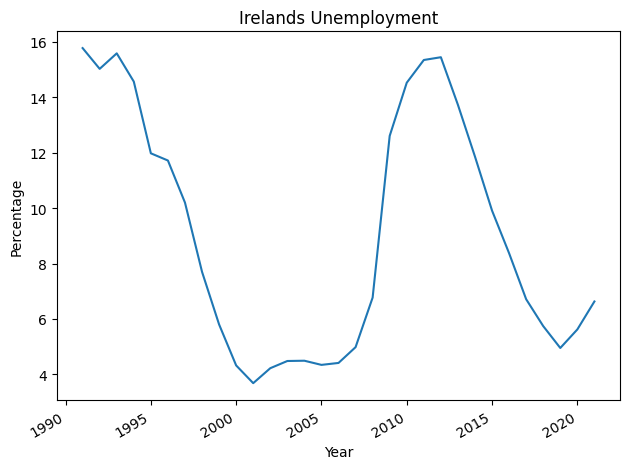

<Figure size 640x480 with 0 Axes>

In [ ]:

fig = plt.figure()
plt.plot(df.year, df.percentage)
plt.title('Irelands Unemployment')
plt.xlabel('Year')
plt.ylabel('Percentage')

plt.xticks(rotation = 100, ha='right')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()
plt.savefig('airplane.png', dpi=300)

In [ ]:
ADF_result = adfuller(df['percentage'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.659059038214447
p-value: 0.08139470206554483


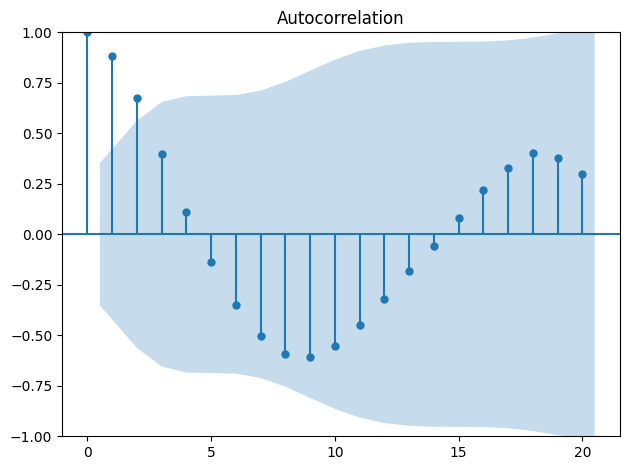

In [ ]:
plot_acf(df['percentage'], lags=20);

plt.tight_layout()
plt.savefig('fig_percentage.png', dpi=300)

In [ ]:
percentage_diff=np.diff (df['percentage'], n=1)
print(percentage_diff)

[-0.75  0.56 -1.02 -2.59 -0.26 -1.52 -2.5  -1.9  -1.48 -0.64  0.54  0.26
  0.01 -0.15  0.07  0.57  1.79  5.84  1.92  0.82  0.1  -1.72 -1.87 -1.95
 -1.54 -1.66 -0.97 -0.79  0.67  1.01]


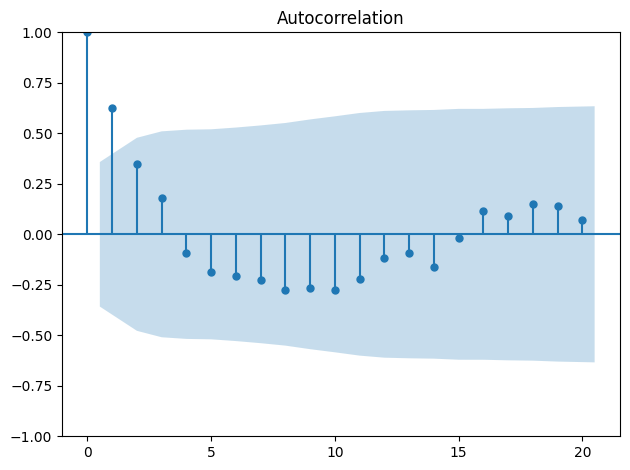

In [ ]:
plot_acf(percentage_diff, lags=20);

plt.tight_layout()
plt.savefig('fig_percentage_diff.png', dpi=300)

In [ ]:
ADF_result = adfuller(percentage_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.3932269276004563
p-value: 0.14365719089875095


In [ ]:
df_diff = pd.DataFrame({'percentage_diff': percentage_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

27
3


In [ ]:
model = SARIMAX(df_diff[:449], order=(0,0,2))
res = model.fit(disp=False) # Train the models

            
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:        percentage_diff   No. Observations:                   30
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 -50.996
Date:                Mon, 08 May 2023   AIC                            107.992
Time:                        13:44:53   BIC                            112.196
Sample:                             0   HQIC                           109.337
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6686      0.173      3.857      0.000       0.329       1.008
ma.L2          0.1664      0.213      0.782      0.434      -0.250       0.583
sigma2         1.7276      0.309      5.594      0.0

In [ ]:
predictions = res.get_prediction(0, 38 + 2)

predictions.predicted_mean

0     0.000000
1    -0.396613
2     0.538419
3    -0.891102
4    -1.393845
5     0.475454
6    -1.145546
7    -1.237605
8    -0.668242
9    -0.652969
10   -0.126386
11    0.447721
12   -0.014643
13   -0.014755
14   -0.086328
15    0.082023
16    0.352283
17    1.042482
18    3.446945
19   -0.222758
20    0.443166
21   -0.055959
22   -1.169715
23   -0.745086
24   -0.922147
25   -0.613582
26   -0.802458
27   -0.286123
28   -0.364780
29    0.608047
30    0.440920
31    0.066876
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
Name: predicted_mean, dtype: float64

In [ ]:


def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA


In [ ]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,percentage_diff,pred_mean,pred_last_value,pred_MA
27,-0.79,-0.371852,-0.97,-0.274507
28,0.67,-0.386786,-0.79,-0.366437
29,1.01,-0.350345,0.67,0.591643


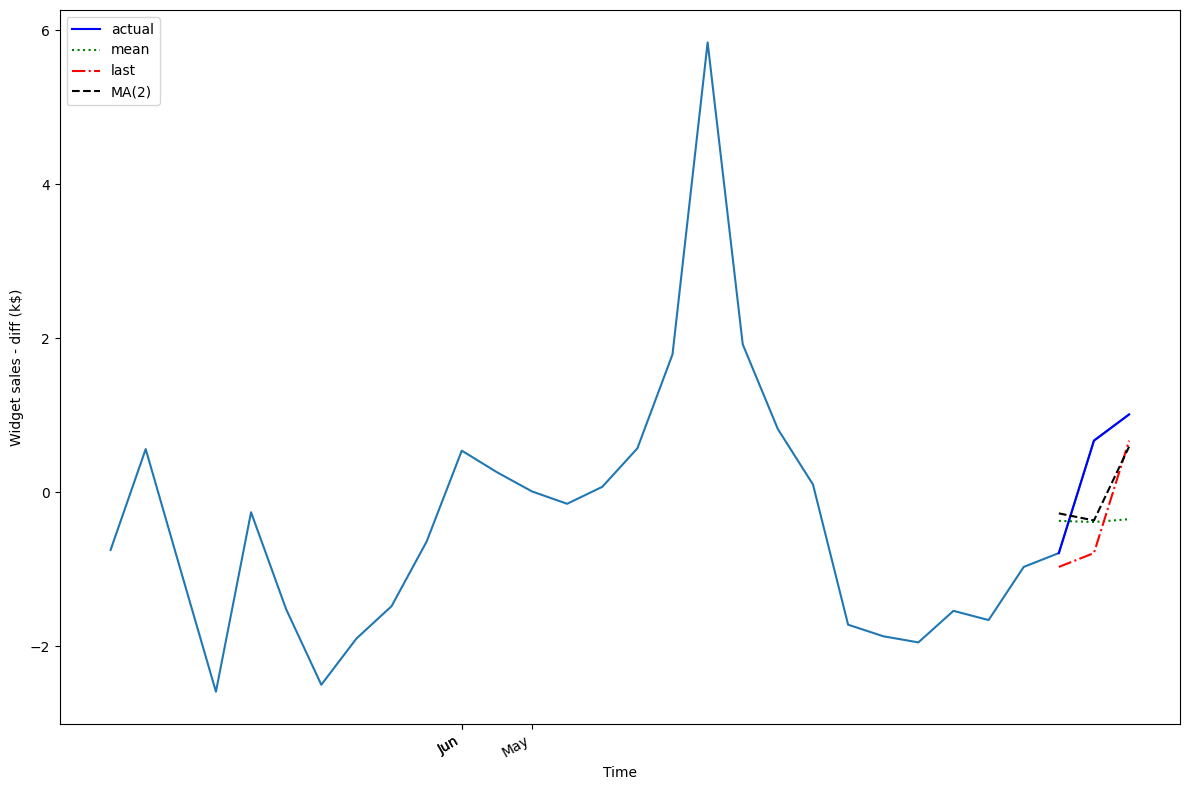

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df_diff['percentage_diff'])
ax.plot(pred_df['percentage_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')


plt.xticks([10, 12, 10], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('irelandUnemployment.png', dpi=300)

In [ ]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['percentage_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['percentage_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['percentage_diff'], pred_df['pred_MA'])

print('%.3f' % mse_mean, '%.3f' % mse_last, '%.3f' % mse_MA)

1.047 0.760 0.505


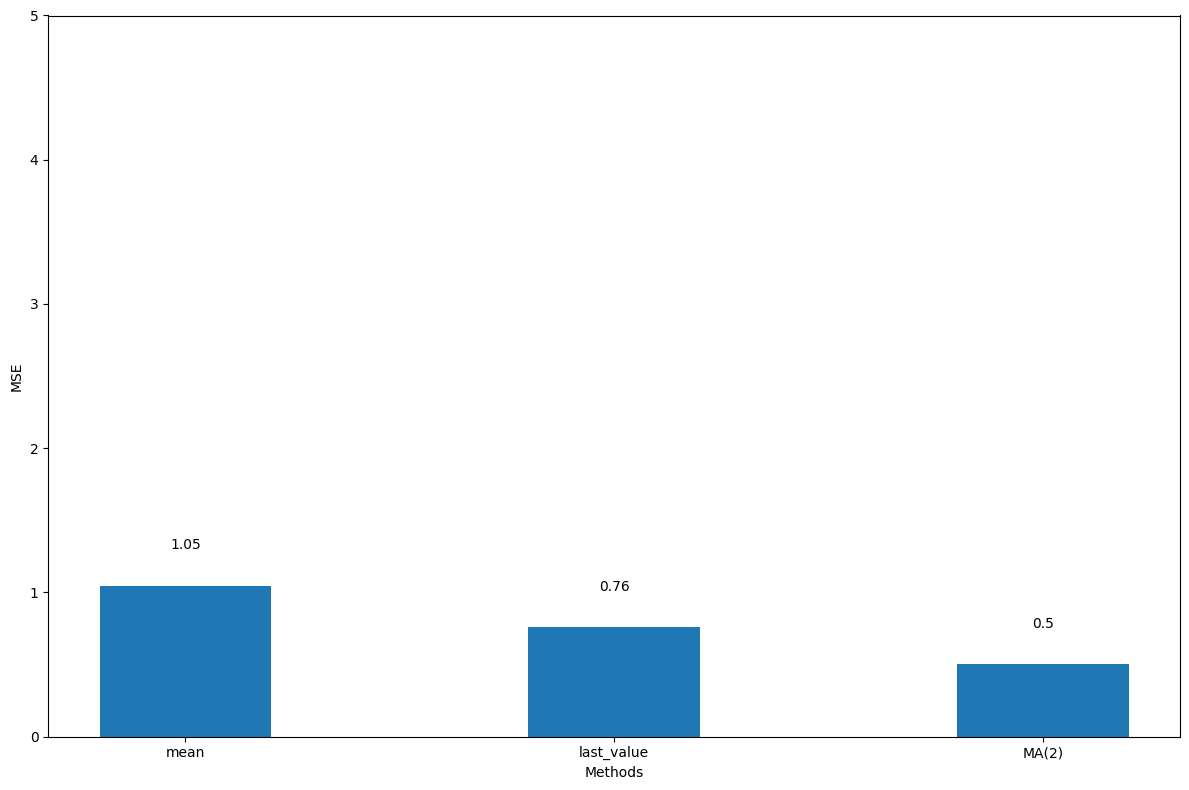

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('irelandUnemployment.png', dpi=300)


In [ ]:
df['pred_percentage'] = pd.Series()
df['pred_percentage'][8:] = df['percentage'].iloc[8:] + pred_df['pred_MA'].cumsum()

<ipython-input-55-cb0415eec041>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['pred_percentage'] = pd.Series()
<ipython-input-55-cb0415eec041>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_percentage'][8:] = df['percentage'].iloc[8:] + pred_df['pred_MA'].cumsum()


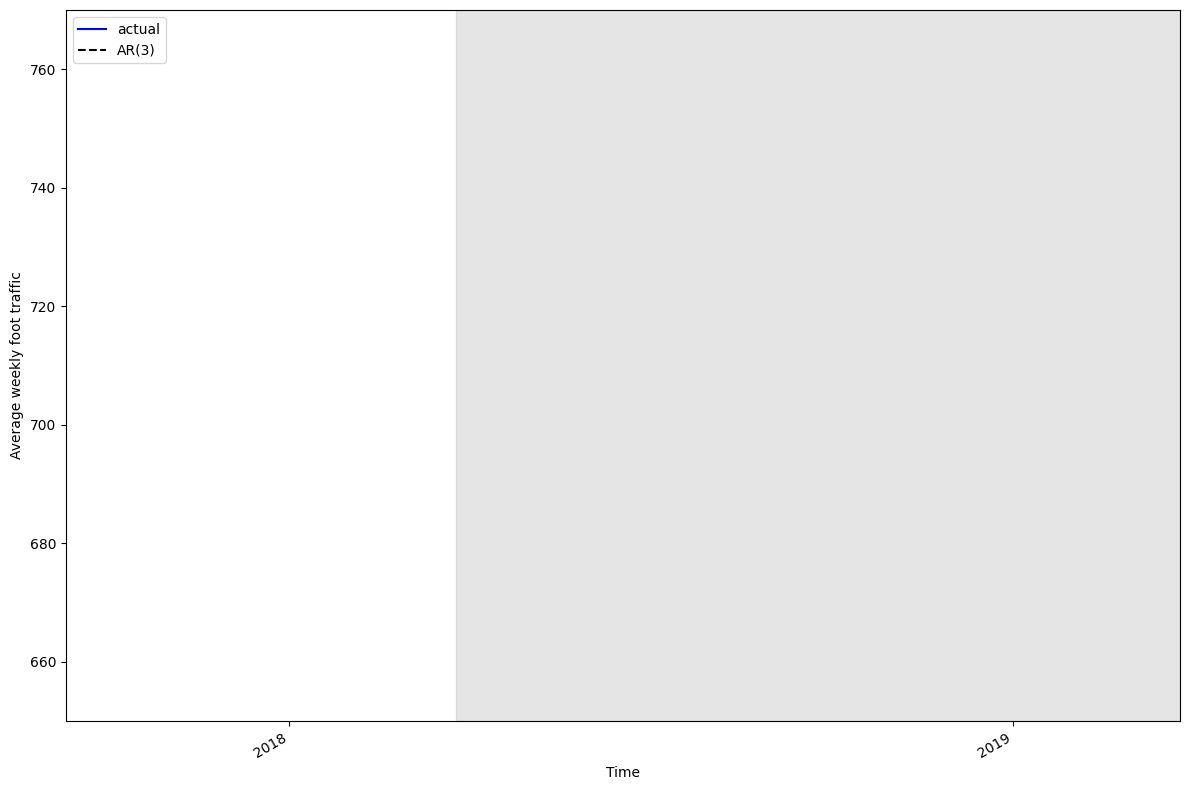

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['percentage'])
ax.plot(df['percentage'], 'b-', label='actual')
ax.plot(df['pred_percentage'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('irelandUnemployment.png', dpi=300)